# Aerial Cactus Identification with Keras

This kernel shows my finished work for this competition. I made a simple convolutional neural network with keras and trained it on a subset of the available data. The main breakthrough for me was creating a training set with an equal number of images of each class. One challenge I ran into was loading a model with the tensorflow.keras module -- it just doesn't seem to work with Tensorflow 1.13. To fix this I just used the original keras module as many others did. 

I am amazed by the quality and quantity of work that so many people put into this competition, and it was inspirational reading many polished kernels when I was getting started.

## Step 1: Examine the data

The first step in any data science project is to get an understanding of what you are working with. In this step, I declare my imports and paths to important locations on disk, load some data into memory, and examine it more closely.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

sns.set()

Using TensorFlow backend.


In [2]:
cactus_dir = "../input/aerial-cactus-identification/"
train_dir = cactus_dir + "/train/train/"
test_dir = cactus_dir + "/test/test/"

df_train_data = pd.read_csv(cactus_dir + "/train.csv")
df_train_data['has_cactus'] = df_train_data['has_cactus'].astype(str)

df_test = pd.read_csv(cactus_dir + "/sample_submission.csv")

Let's see what the 'train.csv' file has for us

In [3]:
df_train_data.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


We see that each row is a filename ('id') and a class ('has_cactus'). Now let's see how many of each class we have:

In [4]:
print("The number of training images is: {}".format(len(df_train_data)))

df_train_data['has_cactus'].value_counts()

The number of training images is: 17500


1    13136
0     4364
Name: has_cactus, dtype: int64

So we have 17500 images total and just 4364 do not have a cactus in them. In other words, 75% of the training data consists of images with a cactus in it. To achieve better-than-random results, we'll have to do better than that. 

Now let's see what some of these images look like:

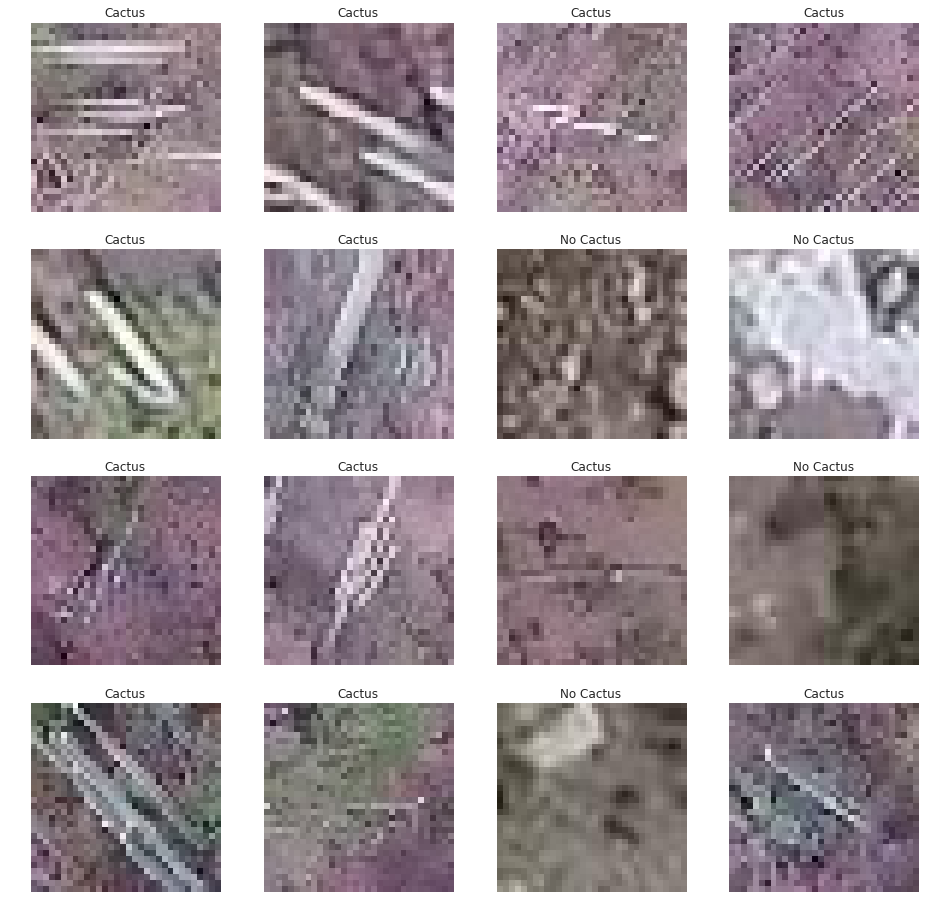

In [5]:
display, axes = plt.subplots(4, 4, figsize=(16, 16))
imgs = []
labels = []
for i, row in df_train_data.head(16).iterrows():
    fname = os.path.join(train_dir, row['id'])
    imgs.append(load_img(fname))
    labels.append('Cactus' if row['has_cactus'] == '1' else 'No Cactus')

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(imgs[i])
    ax.set_title(labels[i])
    ax.axis('off')
plt.show()

Looking at a single image it is hard to immediately recognize that there is a cactus present. When we look at the images altogether a pattern is more clear -- long, straight lines seem to be the strongest identifier of a cactus in the images above. A simple convolutional network would probably do well on this data because it will be able to identify those long, straight features.

## Step 2: Prepare the Data for Keras

This is one of the most important steps in the ML process. If your data isn't prepared the right way for your model, then you might as well not have it. Luckily for us, the data has already been collected and formatted quite nicely. The remaining steps for us are to build training and validation sets, create a pipeline to load images into memory, and set up the ImageDataGenerator class from Keras to do some training data augmentation. 

### Training and Validation Sets
We need to create training and validation sets for our model. It is critical that these sets are disjoint -- no shared elements -- so that the validation set can be a true measure of our model's performance as it learns on the training data. 

I decided that my training set should be 50% images with a cactus and 50% images without a cactus so that the model would not initially have a bias towards classifing images as containing a cactus. On the other hand, I wanted my validation set to be 75% images with a cactus and 25% images without a cactus so it would be representative of the data overall.  

In [6]:
has_cactus = df_train_data[df_train_data['has_cactus'] == '1']
not_cactus = df_train_data[df_train_data['has_cactus'] == '0']

In [7]:
# Want 80% of not_cactus to make up 50% of the training set
df_train = not_cactus[:3491]
df_train = df_train.append(has_cactus[:3491])
df_train = df_train.sample(frac=1).reset_index(drop=True)

df_train['has_cactus'].value_counts()

0    3491
1    3491
Name: has_cactus, dtype: int64

In [8]:
# Want remainder of not_cactus to make up 25% of the validation set
df_valid = not_cactus[3491:]  # Has 873 elements
df_valid = df_valid.append(has_cactus[3491:3491 + 873*3])
df_valid = df_valid.sample(frac=1).reset_index(drop=True)

df_valid['has_cactus'].value_counts()

1    2619
0     873
Name: has_cactus, dtype: int64

### Data Augmentation and Pipeline

Now that our training and validation sets have been established we can move on to the next step in the process, which is to create a pipeline to feed training images to our network. This is the part that I was most intimidated by when I first started coding in this competition, but tinkering with this next bit turned out to be one of my favorite parts of the whole thing. Keras makes this pretty straightforward:

In [9]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(rotation_range=50, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   horizontal_flip=True, 
                                   rescale=1./255)

# No augmentation for validation data
valid_datagen = ImageDataGenerator(rescale=1./255)

Keras also gives you an option to resize your images. I also scaled up the images by a factor of 2 here because that seemed to work better when I was testing.

In [10]:
# Parameters for resizing the image and number of images in a training/validation batch
new_image_size = 64
batch_size = 128

# Data pipeline: filename - dataframe --> image on disk --> keras model

# Training data pipeline
train_generator = train_datagen.flow_from_dataframe(df_train, 
                                                    directory=train_dir, 
                                                    x_col='id', 
                                                    y_col='has_cactus', 
                                                    target_size=(new_image_size, new_image_size), 
                                                    class_mode='binary', 
                                                    batch_size=batch_size)

# Validation: exactly the same except flows from validation dataframe
valid_generator = valid_datagen.flow_from_dataframe(df_valid, 
                                                    directory=train_dir, 
                                                    x_col='id', 
                                                    y_col='has_cactus', 
                                                    target_size=(new_image_size, new_image_size),
                                                    class_mode='binary',
                                                    batch_size=batch_size)

Found 6982 validated image filenames belonging to 2 classes.
Found 3492 validated image filenames belonging to 2 classes.


## Step 3: Building and Training a Convolutional Network

In this part we need to build our model, train it on our training data, and see how it performs. Once again, Keras makes this pretty straightforward.

### Building a Model

We use the Keras Sequential API because this problem does not seem to require complex network architectures that the functional API is capable of providing. A simple CNN with some regularization (Dropout and Maxpooling2D) should do just fine! Here's my network:

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(new_image_size, new_image_size, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 29, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
__________

Now we compile the model using the AdamOptimizer with default settings and Binary Crossentropy as our loss metric. Accuracy is monitored because we need to be able to report how our model does on the training and validation sets. Additionally, we also create several callbacks which will help us during training. 

In [12]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [13]:
# Save the model every time its best validation accuracy improves
checkpoint = ModelCheckpoint("model.hdf5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

# Reduce the learning rate when the model's performance begins to stagnate 
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                              factor=.2,
                              patience=10, 
                              min_lr=1e-9,
                              verbose=1)

# Using early stopping with a high patience value to balance improvement & my own patience
early_stop = EarlyStopping(monitor='val_acc', 
                           patience=100, 
                           verbose=1, 
                           mode='auto', 
                           baseline=None, 
                           restore_best_weights=True)

### Training the Model

Now that our model is compiled and we've setup some callbacks to use during training, we can finally train our model. Note that we use model.fit_generator instead of model.fit because we set up our data pipeline with generators. This takes quite a while, so I'm going to load the model that I trained overnight on my own computer instead. 

In [14]:
# hist = model.fit_generator(train_generator, 
#                            steps_per_epoch=len(df_train)//batch_size, 
#                            epochs=1000, 
#                            validation_data=valid_generator, 
#                            validation_steps=len(df_valid)//batch_size, 
#                            callbacks=[checkpoint, reduce_lr, early_stop],
#                            verbose=0)

model = load_model('../input/best-model-1/model.hdf5')

Normally, I would plot the model's accuracy as a function of the number of epochs it trained, but we can't do this when we are just loading the model, so this is commented out here.

In [15]:
# def plot_from_history(history):
#     history_dict = history.history
#     loss = history_dict['loss']
#     val_loss = history_dict['val_loss']
#     acc = history_dict['acc']
#     val_acc = history_dict['val_acc']
#     epochs = range(1, len(loss) + 1)
    
#     fig, ax1 = plt.subplots(1, figsize=(8, 4), dpi=150)
#     ax1.set_title('Accuracy vs Epoch')
#     ax1.plot(epochs, acc, label='Training Accuracy')
#     ax1.plot(epochs, val_acc, label='Validation Accuracy')
#     ax1.legend(loc='best')
#     plt.show()

# plot_from_history(hist)

We report the model's final validation accuracy so we know what to expect for our results (This can be done when loading the model).

In [16]:
model.evaluate_generator(valid_generator, steps=len(df_valid)//batch_size)

[0.01134091289282811, 0.9973958333333334]

## Making Predictions

Now that the model is trained, we can use it to make predictions on the test data. This will be what we submit to the competition. Our first step is to load the test data into memory, which we can do with the keras.preprocessing.image load_img and img_to_array functions. 

In [17]:
test_fnames = []
test_imgs = []
for fname in os.listdir(test_dir):
    test_fnames.append(fname)
    img = load_img(test_dir + fname, target_size=(new_image_size, new_image_size, 3))
    img = img_to_array(img) / 255
    test_imgs.append(img)
test_imgs = np.array(test_imgs)

test_imgs.shape

(4000, 64, 64, 3)

Now we make the predictions (Note that I do not use the predict_classes function):

In [18]:
pred = model.predict(test_imgs)
pred[:5]

array([[1.2218952e-06],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

Finally, we save the predictions to the disk. Make sure to set index=False, otherwise you'll end up with an extra column in your csv file that you submit... I learned that the hard way.

In [19]:
submission = pd.DataFrame()
submission['id'] = test_fnames
submission['has_cactus'] = pred
submission.to_csv('submission.csv', index=False)

submission.head()

,id,has_cactus
0,34d12362206bf3becb77fb0e50ec7a6b.jpg,0.000001
1,b90d27d9ab51c85ebf2b7c3610f9650f.jpg,1.000000
2,1a1ca91fbd12af9c4cd4d1079b8c832c.jpg,1.000000
3,36219f1335a4d56041fa1139a9c27f3f.jpg,1.000000
4,bde96aabc07264b2ca48d7f23dde6964.jpg,1.000000
